In [29]:
import duckdb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load design matrix from gold schema

Transformations and preparation done in `dbt` project.

In [37]:
data_dir = '../data/ppp_loan_analysis.duckdb'
with duckdb.connect(data_dir) as conn:
    query = """
        SELECT *
        FROM gold.wage_adjusted_ppp_target
    """
    df = conn.execute(query).df()
df.head()

,county,state,urbanicity,ppp_loan_amount,total_annual_wages,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,trump_share
0,Maricopa County,Arizona,urban,9.367912e+09,3.397178e+11,0.027576,0.827994,0.063833,0.046308,0.031203,0.314097,0.476684
1,Collin County,Texas,urban,2.596440e+09,8.333645e+10,0.031156,0.692616,0.108620,0.162953,0.007864,0.155244,0.556180
2,Miami-Dade County,Florida,urban,9.470466e+09,1.812786e+11,0.052243,0.790489,0.177317,0.016236,0.003355,0.694297,0.340744
3,Webb County,Texas,urban,3.713041e+08,1.010713e+10,0.036737,0.975738,0.007349,0.006159,0.006322,0.953899,0.227520
4,Caldwell County,North Carolina,urban,7.865806e+07,2.794965e+09,0.028143,0.915050,0.051571,0.007532,0.007459,0.059067,0.732957


In [38]:
df_clean = df.dropna()
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'

## Identify numerical correlations


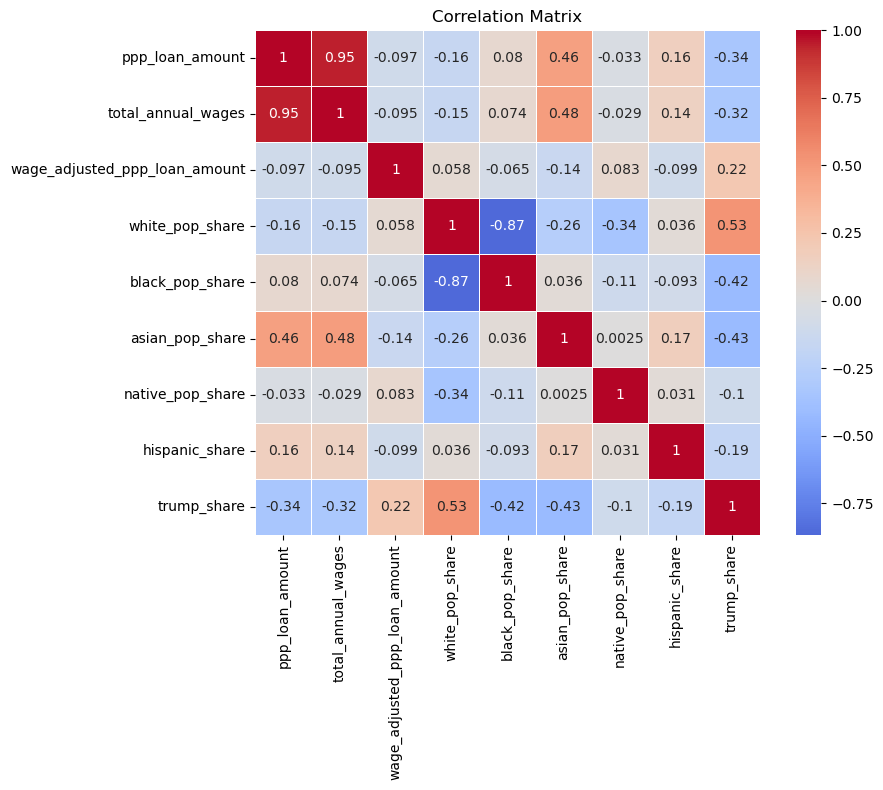

In [39]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Evaluate regression with urbanicity

In [45]:
formula = f"np.log(ppp_loan_amount) ~ white_pop_share + black_pop_share + asian_pop_share + hispanic_share + trump_share + C(urbanicity, Treatment(reference='urban'))"
model = smf.ols(formula, data=df).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log(ppp_loan_amount)   R-squared:                       0.568
Model:                                 OLS   Adj. R-squared:                  0.567
Method:                      Least Squares   F-statistic:                     582.9
Date:                     Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                             01:35:05   Log-Likelihood:                -4610.8
No. Observations:                     3113   AIC:                             9238.
Df Residuals:                         3105   BIC:                             9286.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

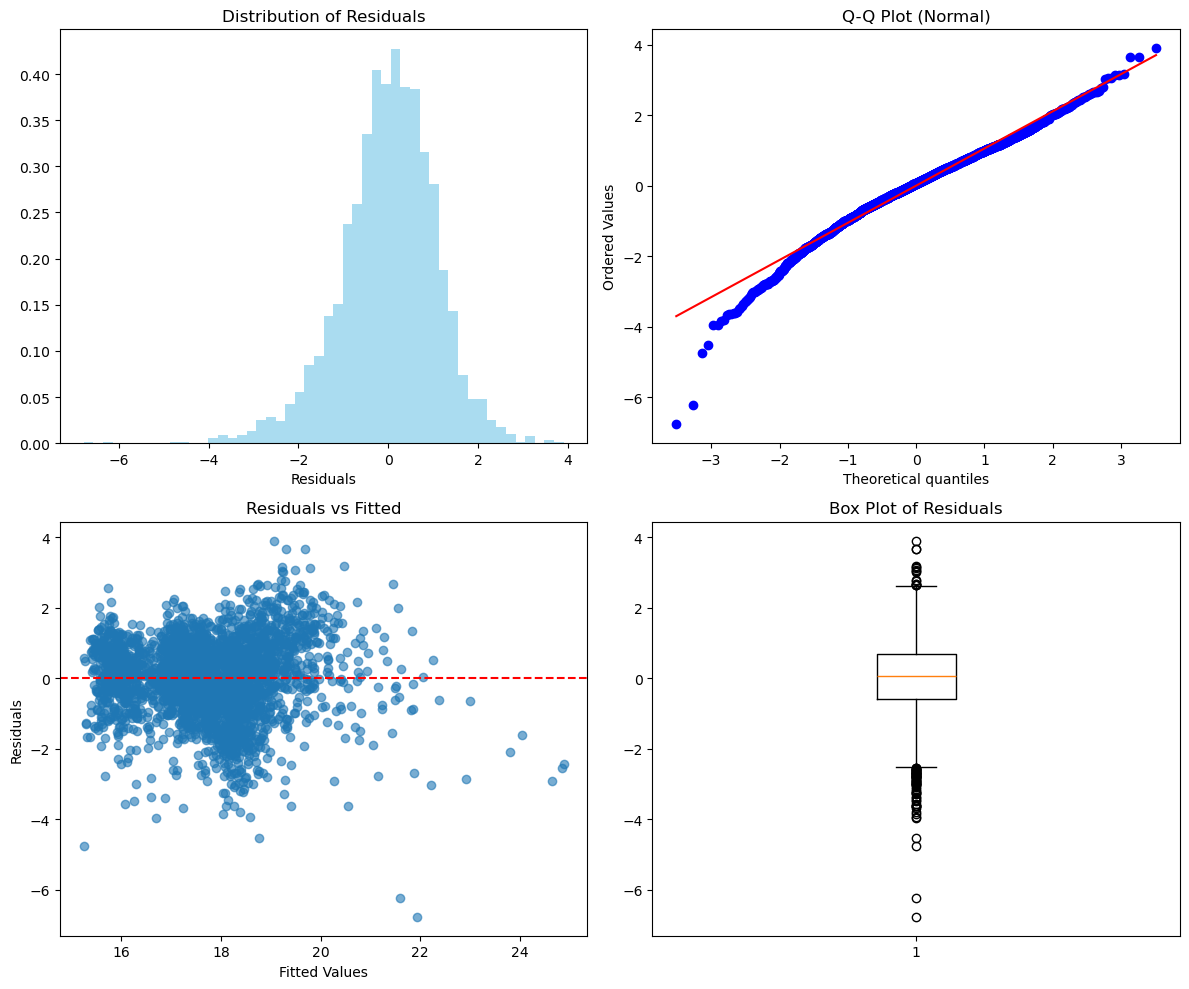

In [46]:
# Get residuals from your model
residuals = model.resid

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Histogram
axes[0,0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Residuals')
axes[0,0].set_xlabel('Residuals')

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot (Normal)')

# 3. Residuals vs Fitted
fitted = model.fittedvalues
axes[1,0].scatter(fitted, residuals, alpha=0.6)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Fitted Values')
axes[1,0].set_ylabel('Residuals')
axes[1,0].set_title('Residuals vs Fitted')

# 4. Box plot
axes[1,1].boxplot(residuals)
axes[1,1].set_title('Box Plot of Residuals')

plt.tight_layout()
plt.show()